In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Goal

Predict the California Housing District Prices based on the dataset

## Machine Learning Design

- Supervised -> target variable are provided
- Batch/Offline -> based 
- NOT-OUT of Core -> all the dataset can fit into memory


In [93]:
# Get the dataset

housing_df = pd.read_csv("../datasets/housing.csv")

housing_df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### Appears we have a categorical data in the *ocean_proximity* attributes

In [94]:
# get the info about the dataset

housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are missing values in the *total_bedrooms* attribute ~ 200

!TODO: clean this column.

In [96]:
# get the catgeorical variable in ocean_proximity

housing_df.ocean_proximity.value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

#### Let's visualize the dataset by checking the distribution

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

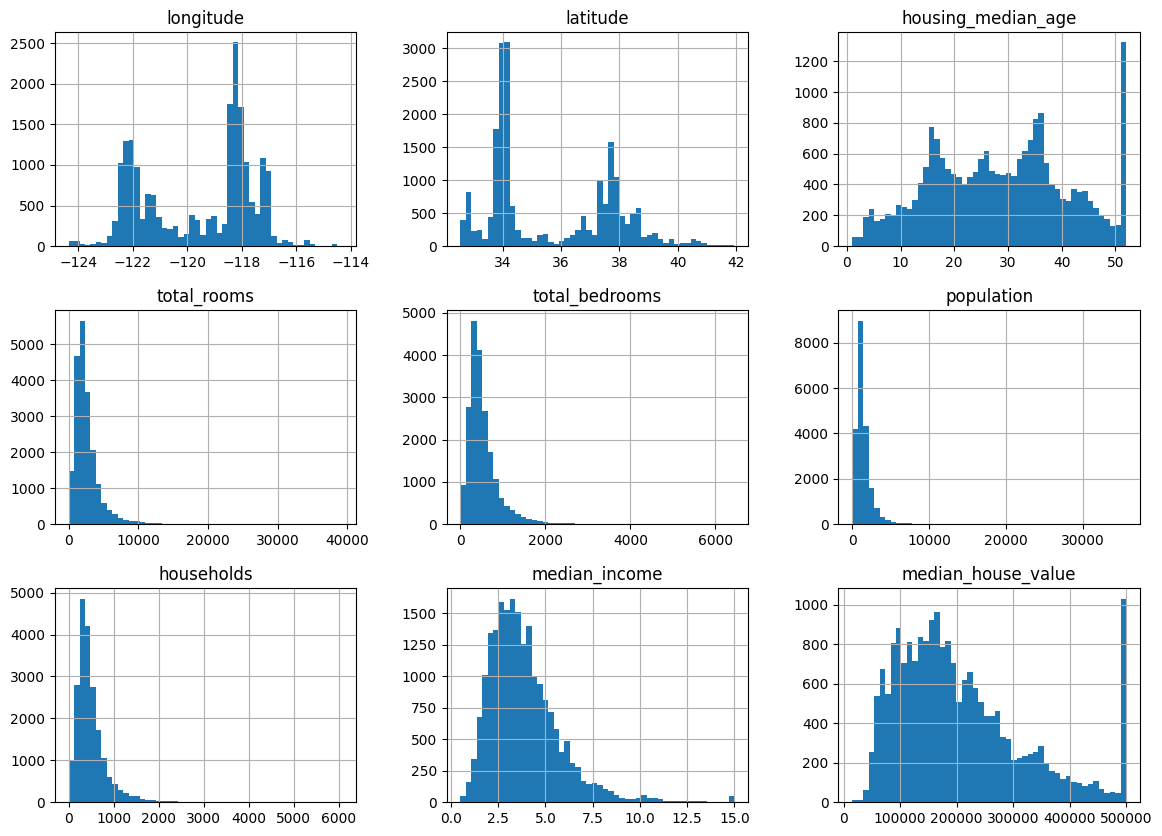

In [106]:
housing_df.hist(bins=50, figsize=(14, 10))

#### Observations:

- Most of the attributes are skewed to the right; **total_rooms, total_bedrooms, population, households, median_income, and median_house_value** ==> (the mean is greater than the median) the data is biased.
- The **median_income** values are scaled down by 10,000th. which implies that the true value will be 
- 
        true value = value x 10,000
---
---

#### Before further Observations, we get the test set data

In [166]:
# write a function that randomly sample 20% of the dataset as the test set

def shuffle_split(data, test_ratio=0.2):
    # get the same shuffled indices
    np.random.seed(42)

    # get the shuffle indices
    shuffle_index = np.random.permutation(len(data))

    # compute number of test instances
    test_size = np.int64(test_ratio * len(data))

    test_indices = shuffle_index[:test_size]
    train_indices = shuffle_index[test_size:]

    return housing_df.iloc[train_indices], housing_df.iloc[test_indices]

In [110]:
train_set, test_set = shuffle_split(housing_df)

print(len(train_set), len(test_set))

16512 4128


### Sampling Bias and Stratified Sampling

By sampling in this manner, there is a possibility that we have used values in the test set that is not representative of the entire dataset.

To avoid this, we have to use **stratified sampling** by categorizing all the instances into a finite number of *not too small or large** categories.

This is achieved by using the most important attributes as the categorical data. In this case, it is **median_income**

In [119]:
# divide the dataser using the median income attribute

bins = [0., 1.5, 3.0, 4.5, 6., np.inf]

housing_df['income_cat'] = pd.cut(housing_df["median_income"], bins=bins, labels=[1, 2, 3, 4, 5])

In [120]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


In [126]:
housing_df.income_cat.value_counts().sort_index()

income_cat
1     822
2    6581
3    7236
4    3639
5    2362
Name: count, dtype: int64

In [178]:
# get the percentage using the category
from collections import defaultdict

def stratify_percentage(dataframe, attribute):
    # get the number of categories
    # p = len(dataframe[attribute].unique())

    res = defaultdict(int)
    for i, p in enumerate(dataframe[attribute].value_counts().sort_index()):
        res[i+1] = f"{int(p/len(dataframe) * 100)}%"

    return res

To avoid or reduce sampling bias, then of the 20% of the test size,

- ~3.9% must have 0 <=median_income < 15k

- ~31.9% must have $15k <=median_income < $30k

- ~35.0% must have $30k <=median_income < $45k

- ~17.6% must have $45k <=median_income < $60k

- ~11% must have median_income >= $60k

This sampling method, aka **STRATIFIED SAMPLING** allows for the test set to represent the entire dataset

Text(0, 0.5, 'Number of Districts')

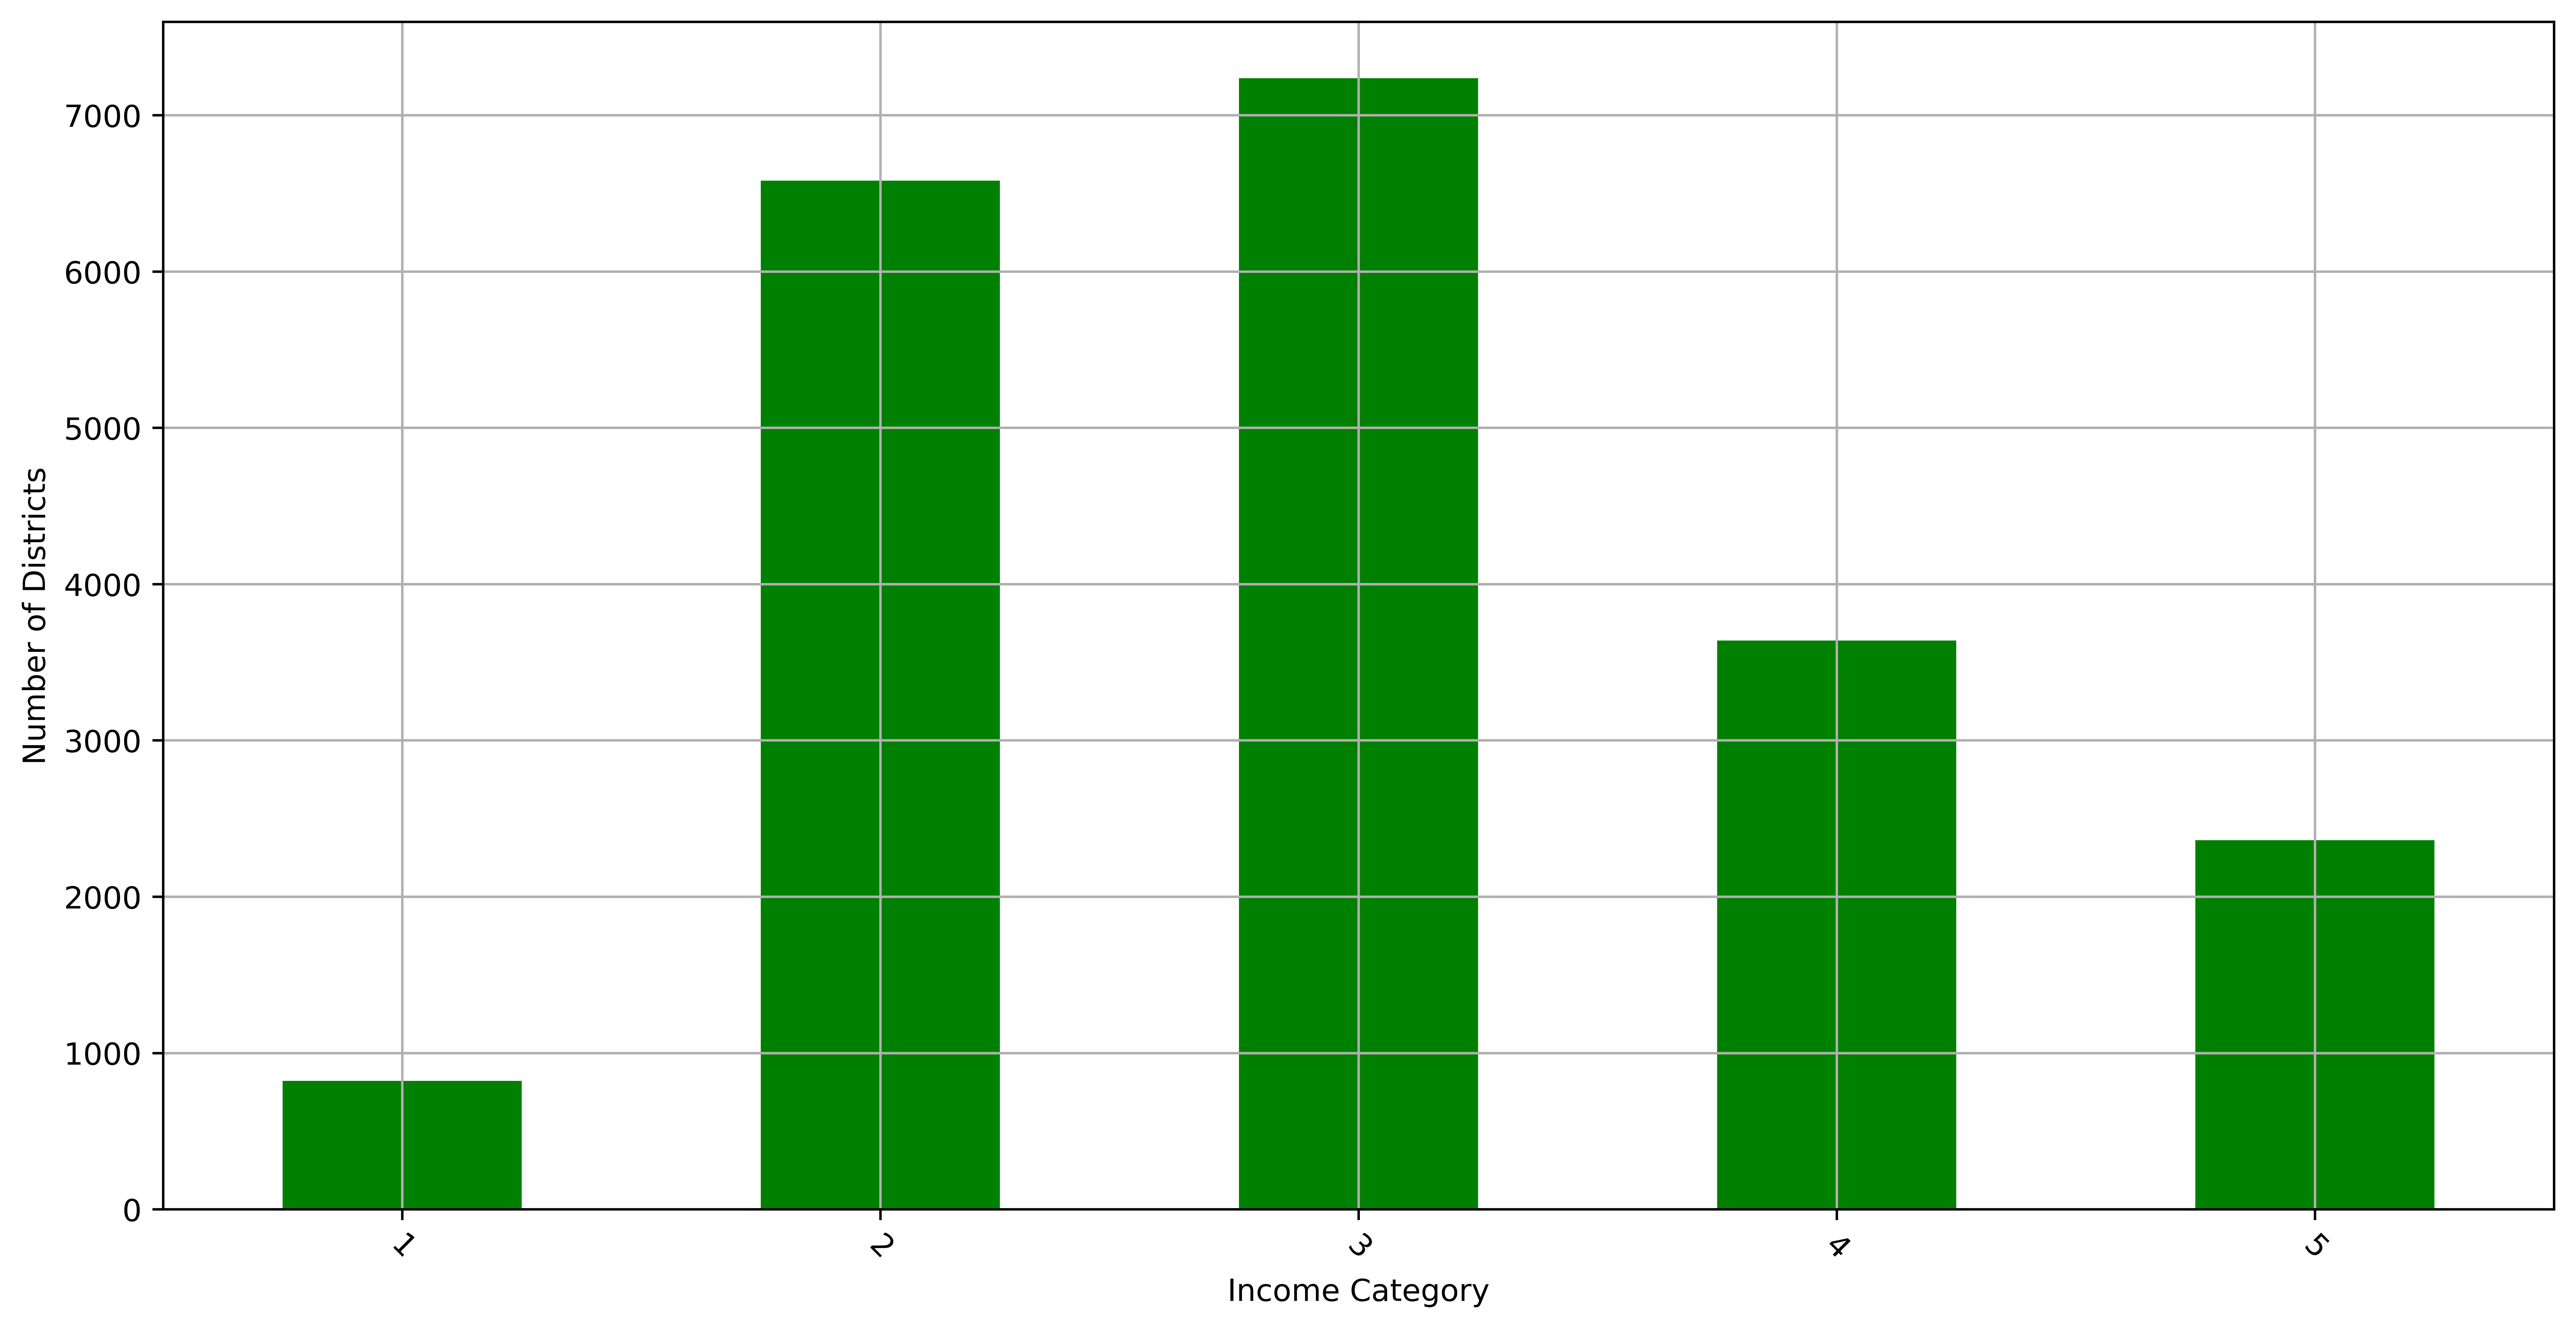

In [139]:
# visualize the data

plt.figure(figsize=(14, 7), dpi=800)
housing_df.income_cat.value_counts().sort_index().plot.bar(rot=-45, grid=True, color='green')
plt.xlabel("Income Category")
plt.ylabel("Number of Districts")

In [164]:
# how do we get the test set based on this??

train_set, test_set = train_test_split(housing_df, test_size=0.2, random_state=42, shuffle=True, stratify=housing_df['income_cat'])

print(len(train_set), len(test_set))

16512 4128


In [179]:
# get the percentage of the categories in the test and train set

print(stratify_percentage(housing_df, 'income_cat'))
print(stratify_percentage(train_set, 'income_cat'))
print(stratify_percentage(test_set, 'income_cat'))

defaultdict(<class 'int'>, {1: '3%', 2: '31%', 3: '35%', 4: '17%', 5: '11%'})
defaultdict(<class 'int'>, {1: '3%', 2: '31%', 3: '35%', 4: '17%', 5: '11%'})
defaultdict(<class 'int'>, {1: '3%', 2: '31%', 3: '35%', 4: '17%', 5: '11%'})
